# It creates a map with city's districts and sensors' locations

TO DO:
    Print a table with precise sensors' locations

In [9]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib
import matplotlib.image as image

from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
import geopandas as gpd
import pyproj

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10


In [2]:
import requests

headers = {
    'Accept': 'application/json',
    'apikey': '***',
}

#rybnik's geographical coordinates
params = (
    ('southwestLat', '50.033'),
    ('southwestLong', '18.428'),
    ('northeastLat', '50.180'),
    ('northeastLong', '18.662'),
)

response = requests.get('https://airapi.airly.eu/v1/sensors/current', headers=headers, params=params)

In [3]:
data_js = response.json()

#only official rybnik's sensors
df_temp = pd.DataFrame.from_records(data_js).query("name == 'Rybnik' and vendor == 'Airly'")

#unfold address dict
df_temp = pd.concat([df_temp.drop(['address'], axis=1), df_temp['address'].apply(pd.Series)], axis=1)
#unfold location dict
sensors = pd.concat([df_temp.drop(['location'], axis=1), df_temp['location'].apply(pd.Series)], axis=1).reset_index(drop=True)

In [4]:
sensors['district'] = sensors.locality.apply(lambda x: x.split(",")[1])
sensors = sensors.sort_values('district').reset_index(drop=True)

In [5]:
shp = fiona.open('data/city.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [6]:
m = Basemap(
    projection='tmerc',
    lon_0=18,
    lat_0=50.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - 2*extra * w,
    llcrnrlat=coords[1] - 2*extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/city',
    'rybnik',
    color='none',
    zorder=2)

(27,
 5,
 [18.44168423057649, 50.03540818733495, 0.0, 0.0],
 [18.656839587997112, 50.18567083284379, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x16d0b6d8>)

In [7]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.rybnik],
    'ward_name': [ward['name'] for ward in m.rybnik_info]})

df_map = df_map.sort_values('ward_name').reset_index(drop=True)

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(sensors['longitude'], sensors['latitude'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

In [8]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

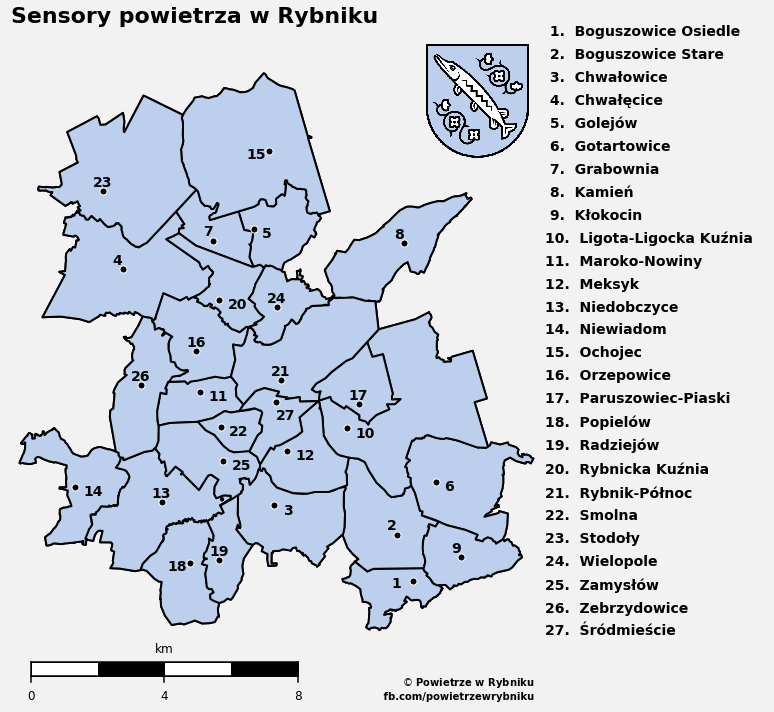

In [13]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#BCD0ED',
    ec='#000000', lw=2., alpha=1.,
    zorder=4))




plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')


im = image.imread('data/rybnik-logo-pelne.png')
ax.imshow(im,aspect='auto',extent=(12000, 16000, 16000, 20000), zorder=-1)



# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    50, marker='o', lw=1.,
    facecolor='#000000', edgecolor='w',
    alpha=1, antialiased=True,
    label='Blue Plaque Locations', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))


# plot numbers near points
for i, geom in enumerate(ldn_points):
    if i in (2,4,5,9,10,11,13,19,21,24):
        plt.text(
            geom.x+250,
            geom.y-250,
            str(i+1), color='K', fontsize=14, weight='semibold', zorder=3)
    elif i in (0,17,14):
        plt.text(
            geom.x-650,
            geom.y-200,
            str(i+1), color='K', fontsize=14, weight='semibold', zorder=3)
    
    elif i in (26,):
        plt.text(
            geom.x,
            geom.y-500,
            str(i+1), color='K', fontsize=14, weight='semibold', zorder=3)
    
    
    else:

        plt.text(
            geom.x-300,
            geom.y+150,
            str(i+1), color='K', fontsize=14, weight='semibold', zorder=3)

        
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))



# Bin method, copyright and source data info
smallprint = ax.text(
    1.00, 0,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)




# List of districts
districts_str = '\n'.join( str("  "+ str(_+1)+".  ")[-5:] +value[1]+"   " for _, value in df_map.iterrows()).decode('utf-8')
ax.text(16000, 2000, districts_str, fontsize=14, linespacing=1.8, fontname='sans',weight='semibold')


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1],
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize = 12, 
    zorder=5)


ttfont = {'fontname':'sans', 'weight':'bold'}



plt.title("Sensory powietrza w Rybniku", fontsize=22, loc='left',**ttfont)
plt.tight_layout()
fig.set_size_inches(12, 10)
#plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()